In [ ]:
import os
import re
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import *
from gensim.parsing.preprocessing import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import *
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
sns.set_theme(style="darkgrid")

# Chạy trước (*)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chọn thư mục hoạt động

HOME = '/content/drive/MyDrive/AI/ML'

!mkdir -p $HOME
%cd $HOME

/content/drive/MyDrive/AI/ML


In [ ]:
# Tạo các thư mục liên quan

!rm -rf models/toxic_comment/
!rm -rf logs/toxic_comment/
!rm -rf imgs/toxic_comment/

!mkdir -p datasets/toxic_comment/
!mkdir -p models/toxic_comment/
!mkdir -p logs/toxic_comment/
!mkdir -p imgs/toxic_comment/

In [ ]:
# Thiết lập đường dẫn chung

ds_path = 'datasets/toxic_comment/'
model_path = 'models/toxic_comment/'
log_path = 'logs/toxic_comment/'
img_path = 'imgs/toxic_comment/'

In [ ]:
# Clone data từ Git & move sang ds_path

!git clone https://github.com/tianqwang/Toxic-Comment-Classification-Challenge
!mv -f Toxic-Comment-Classification-Challenge/* $ds_path
!ls

Cloning into 'Toxic-Comment-Classification-Challenge'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25 (from 1)
Receiving objects: 100% (25/25), 54.22 MiB | 8.72 MiB/s, done.
Updating files: 100% (22/22), done.
datasets  documents  imgs  logs  models  Toxic-Comment-Classification-Challenge


# Khái quát dữ liệu

In [ ]:
# Nạp data vào bộ nhớ

train_df = pd.read_csv(os.path.join(ds_path, 'data', 'train.csv'), delimiter=',')
test_df = pd.read_csv(os.path.join(ds_path, 'data', 'test.csv'), delimiter=',')

In [ ]:
# In thử 10 dòng đầu tiên tập Train

train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
# In thử 10 dòng cuối tập Test

test_df

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [ ]:
# Liệt kê các thuộc tính

train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
# Liệt kê các giá trị N/A, loại bỏ nếu có

train_df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [ ]:
# Kiểm tra giá trị ngoại lai

train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Phân bố dữ liệu ở các thuộc tính

In [ ]:
train_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [ ]:
#tính tổng các giá trị lấy từ cột thứ 3
data_count=train_df.iloc[:,2:].sum().sort_values(ascending=False)
data_count

,0
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


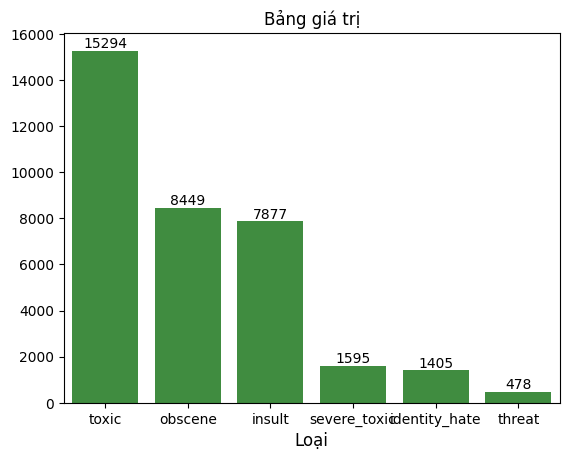

In [ ]:
#Sử dụng phương thức barplot trong Seaborn
#Hiển thị ước tính điểm và khoảng tin cậy dưới dạng thanh hình chữ nhật.
ax = sns.barplot(x=data_count.index, y=data_count.values, alpha=0.8, color='g')

plt.title("Bảng giá trị") # đặt tên biểu đồ
plt.ylabel("", fontsize=12)
plt.xlabel("Loại", fontsize=12) # đặt tên cho trục hoành , set font là 12

#Thêm text cho mỗi cột
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

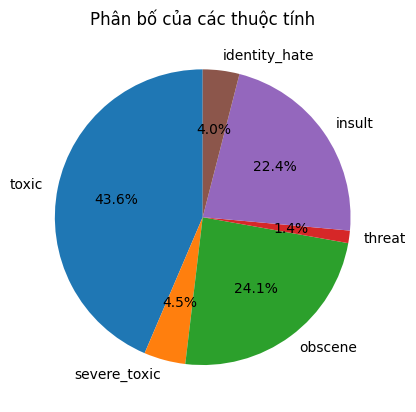

In [ ]:
# Tính tổng giá trị của 6 thuộc tính
column_sum = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

# Vẽ biểu đồ tròn
plt.pie(column_sum, labels=column_sum.index, autopct='%1.1f%%', startangle=90)
plt.title('Phân bố của các thuộc tính')
plt.show()


In [ ]:
#lấy độ dài của data
num_rows=len(train_df)
print(num_rows)

159571


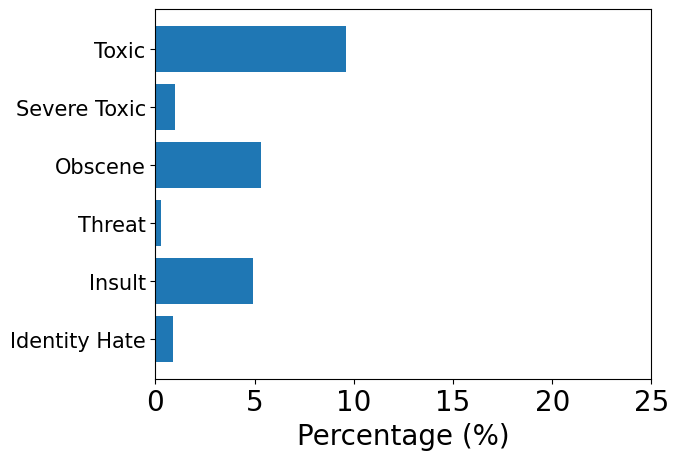

In [ ]:
#Create bar graph
sum_tox = train_df['toxic'].sum() / num_rows * 100
sum_sev = train_df['severe_toxic'].sum() / num_rows * 100
sum_obs = train_df['obscene'].sum() / num_rows * 100
sum_thr = train_df['threat'].sum() / num_rows * 100
sum_ins = train_df['insult'].sum() / num_rows * 100
sum_ide = train_df['identity_hate'].sum() / num_rows * 100

ind = np.arange(6)

ax = plt.barh(ind, [sum_tox, sum_sev, sum_obs, sum_thr, sum_ins, sum_ide])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.yticks(ind, ('Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate'), size=15)

plt.gca().invert_yaxis()
plt.show()

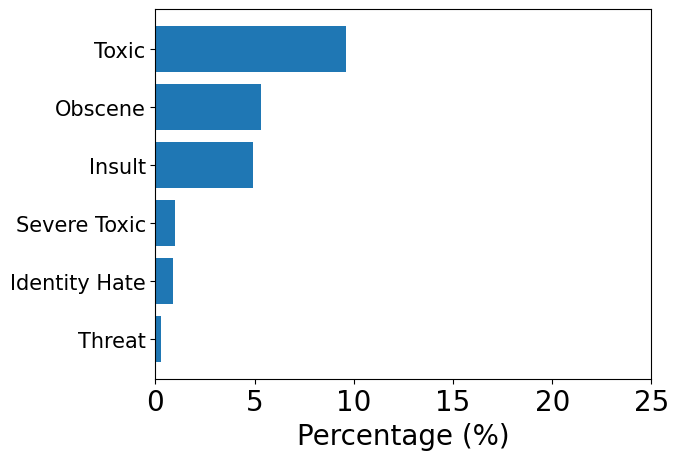

In [ ]:
#Create bar graph
sum_tox = train_df['toxic'].sum() / num_rows * 100
sum_sev = train_df['severe_toxic'].sum() / num_rows * 100
sum_obs = train_df['obscene'].sum() / num_rows * 100
sum_thr = train_df['threat'].sum() / num_rows * 100
sum_ins = train_df['insult'].sum() / num_rows * 100
sum_ide = train_df['identity_hate'].sum() / num_rows * 100

ind = np.arange(6)

ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins,  sum_sev, sum_ide , sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat'), size=15)

plt.gca().invert_yaxis()
plt.show()

# Giai đoạn tiền xử lý dữ liệu & chia section

In [ ]:
# Dựng hàm tiền xử lý Chuỗi comment

def text_preprocessing(text):
  # Chuyển đổi chữ thường
  text = text.lower()
  # Xóa tất cả các số có chữ cái gắn liền với chúng
  text = re.sub(r'\w*\d\w*', ' ', text)
  # Loại bỏ dấu câu
  text = strip_punctuation(text)
  # Loại bỏ kí tự xuống dòng
  text = re.sub("\n", " ", text)
  # Xóa kí tự không phải ascii
  text = strip_non_alphanum(text)
  # Loại bỏ các khoảng trắng thừa
  text = strip_multiple_whitespaces(text)
  return text

In [ ]:
# Áp dụng quá trình tiền xử lý chuỗi cho Dataframe

print('=== TRƯỚC KHI TIỀN XỬ LÝ ===')
print(train_df['comment_text'][0])

train_df['comment_text'] = train_df['comment_text'].apply(text_preprocessing)
test_df['comment_text_preprocessed'] = test_df['comment_text'].apply(text_preprocessing)

print('\n=== SAU KHI TIỀN XỬ LÝ ===')
train_df['comment_text'][0]

=== TRƯỚC KHI TIỀN XỬ LÝ ===
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

=== SAU KHI TIỀN XỬ LÝ ===


'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now '

In [ ]:
# Chia thanh 6 section
data_tox = train_df.loc[:,['id', 'comment_text', 'toxic']]
data_sev = train_df.loc[:,['id', 'comment_text', 'severe_toxic']]
data_obs = train_df.loc[:,['id', 'comment_text', 'obscene']]
data_ins = train_df.loc[:,['id', 'comment_text', 'insult']]
data_thr = train_df.loc[:,['id', 'comment_text', 'threat']]
data_ide = train_df.loc[:,['id', 'comment_text', 'identity_hate']]

print(data_tox.shape, data_sev.shape, data_obs.shape, data_ins.shape, data_thr.shape, data_ide.shape)

(159571, 3) (159571, 3) (159571, 3) (159571, 3) (159571, 3) (159571, 3)


# Trực quan hóa WordCloud

In [ ]:
def wordcloud(df, label):
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc=WordCloud(background_color='black',max_words=4000)
    wc.generate(" ".join(text))
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis('off')
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap='gist_earth', random_state=244), alpha=0.98)

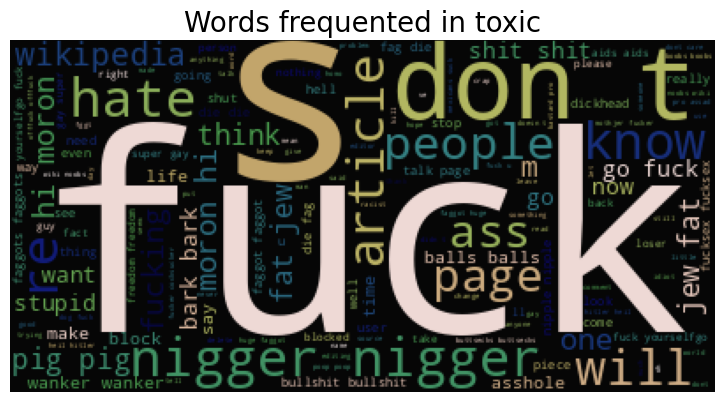

In [ ]:
wordcloud(data_tox,'toxic')

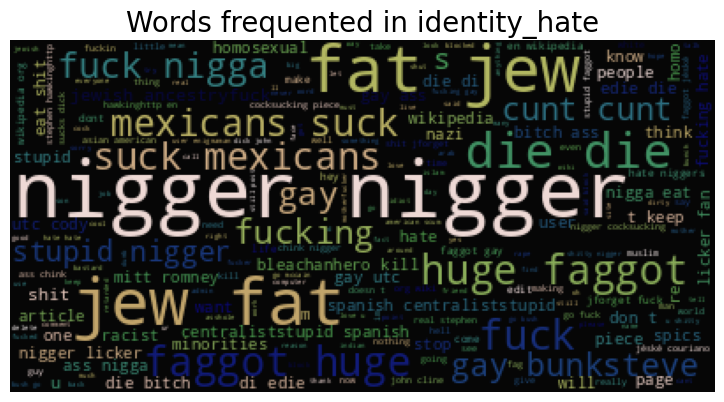

In [ ]:
wordcloud(data_ide,'identity_hate')

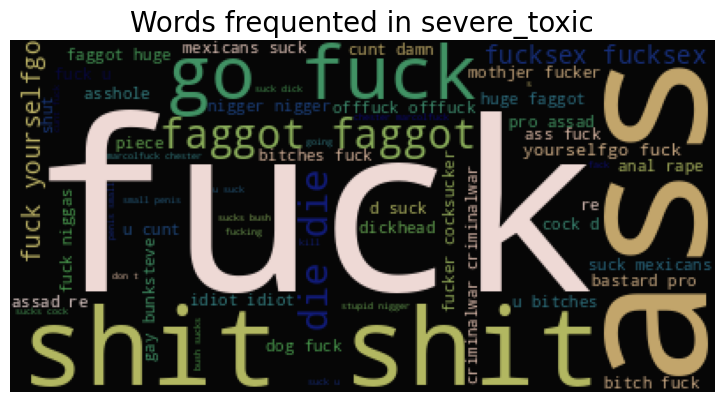

In [ ]:
wordcloud(data_sev,'severe_toxic')

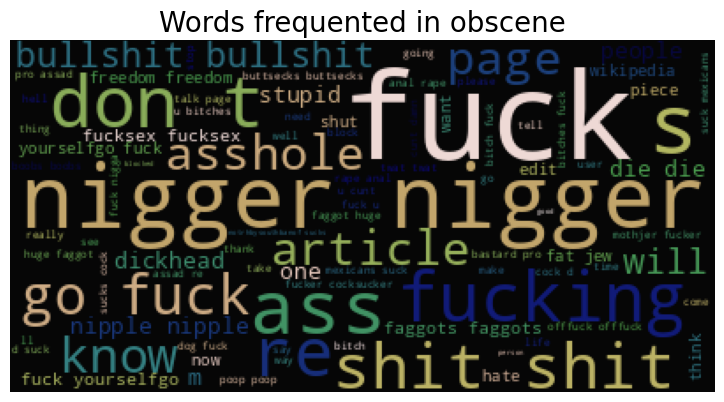

In [ ]:
wordcloud(data_obs,'obscene')

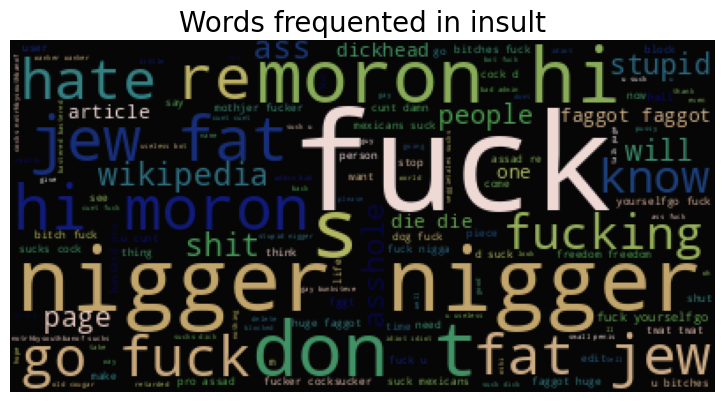

In [ ]:
wordcloud(data_ins,'insult')

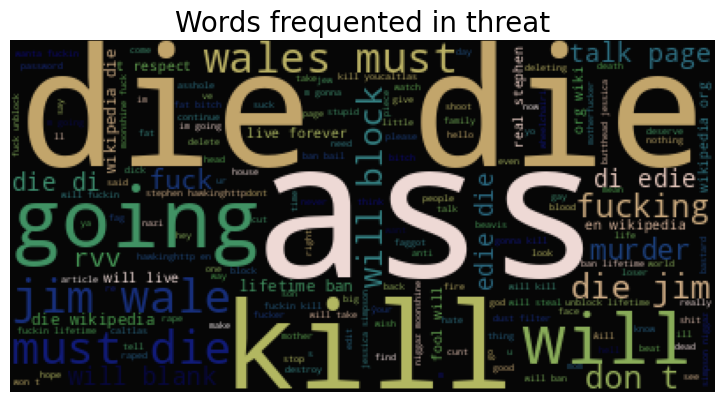

In [ ]:
wordcloud(data_thr,'threat')

# Trích chọn phần tử sao cho các lớp cân bằng nhau

In [ ]:
# Bảng tần số phân bổ các lớp ở từng thuộc tính

for col in train_df.columns[2:]:
  print(train_df[col].value_counts(normalize=True))

toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64
severe_toxic
0    0.990004
1    0.009996
Name: proportion, dtype: float64
obscene
0    0.947052
1    0.052948
Name: proportion, dtype: float64
threat
0    0.997004
1    0.002996
Name: proportion, dtype: float64
insult
0    0.950636
1    0.049364
Name: proportion, dtype: float64
identity_hate
0    0.991195
1    0.008805
Name: proportion, dtype: float64


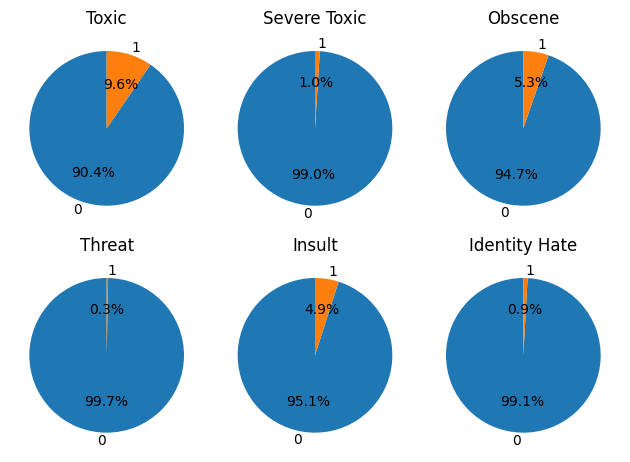

In [ ]:
# Mức độ phân bổ các lớp 0 và 1 ở từng thuộc tính (biểu đồ tròn)

toxic_counts = data_tox['toxic'].value_counts()
severe_toxic_counts = data_sev['severe_toxic'].value_counts()
obscene_counts = data_obs['obscene'].value_counts()
threat_counts = data_thr['threat'].value_counts()
insult_counts = data_ins['insult'].value_counts()
identity_hate_counts = data_ide['identity_hate'].value_counts()

fig, axes = plt.subplots(2, 3)

axes[0, 0].pie(toxic_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Toxic')

axes[0, 1].pie(severe_toxic_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Severe Toxic')

axes[0, 2].pie(obscene_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Obscene')

axes[1, 0].pie(threat_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Threat')

axes[1, 1].pie(insult_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Insult')

axes[1, 2].pie(identity_hate_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Identity Hate')

plt.tight_layout()
plt.show()


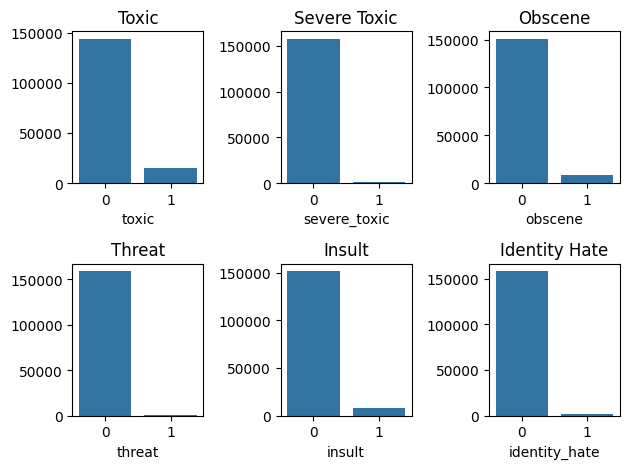

In [ ]:
# Mức độ phân bổ các lớp 0 và 1 ở từng thuộc tính (biểu đồ cột)

toxic_counts = data_tox['toxic'].value_counts()
severe_toxic_counts = data_sev['severe_toxic'].value_counts()
obscene_counts = data_obs['obscene'].value_counts()
threat_counts = data_thr['threat'].value_counts()
insult_counts = data_ins['insult'].value_counts()
identity_hate_counts = data_ide['identity_hate'].value_counts()

fig, axes = plt.subplots(2, 3)

sns.barplot(x=toxic_counts.index, y=toxic_counts.values, ax=axes[0, 0])
axes[0, 0].set_title('Toxic')

sns.barplot(x=severe_toxic_counts.index, y=severe_toxic_counts.values, ax=axes[0, 1])
axes[0, 1].set_title('Severe Toxic')

sns.barplot(x=obscene_counts.index, y=obscene_counts.values, ax=axes[0, 2])
axes[0, 2].set_title('Obscene')

sns.barplot(x=threat_counts.index, y=threat_counts.values, ax=axes[1, 0])
axes[1, 0].set_title('Threat')

sns.barplot(x=insult_counts.index, y=insult_counts.values, ax=axes[1, 1])
axes[1, 1].set_title('Insult')

sns.barplot(x=identity_hate_counts.index, y=identity_hate_counts.values, ax=axes[1, 2])
axes[1, 2].set_title('Identity Hate')

plt.tight_layout()
plt.show()


In [ ]:
## Thuộc tính Toxic

# In số phần tử nhỏ nhất của một lớp
min_toxic = data_tox['toxic'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_toxic)

# Trích chọn phần tử
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_tox_1.shape[0])
print('Lớp 0:', data_tox_0.shape[0])
print('Tổng:', data_tox_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  15294
THỐNG KÊ
Lớp 1: 5000
Lớp 0: 5000
Tổng: 10000


In [ ]:
## Thuộc tính Severve Toxic

# In số phần tử nhỏ nhất của một lớp
min_severve_toxic = data_sev['severe_toxic'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_severve_toxic)

# Trích chọn phần tử
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1500,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1500,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_sev_1.shape[0])
print('Lớp 0:', data_sev_0.shape[0])
print('Tổng:', data_sev_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  1595
THỐNG KÊ
Lớp 1: 1500
Lớp 0: 1500
Tổng: 3000


In [ ]:
## Thuộc tính Obscene

# In số phần tử nhỏ nhất của một lớp
min_obscene = data_obs['obscene'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_obscene)

# Trích chọn phần tử
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_obs_1.shape[0])
print('Lớp 0:', data_obs_0.shape[0])
print('Tổng:', data_obs_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  8449
THỐNG KÊ
Lớp 1: 5000
Lớp 0: 5000
Tổng: 10000


In [ ]:
## Thuộc tính threat

# In số phần tử nhỏ nhất của một lớp
min_threat = data_thr['threat'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_threat)

# Trích chọn phần tử
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:400,:]
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:400,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_thr_1.shape[0])
print('Lớp 0:', data_thr_0.shape[0])
print('Tổng:', data_thr_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  478
THỐNG KÊ
Lớp 1: 400
Lớp 0: 400
Tổng: 800


In [ ]:
## Thuộc tính insult

# In số phần tử nhỏ nhất của một lớp
min_insult = data_ins['insult'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_insult)

# Trích chọn phần tử
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_ins_1.shape[0])
print('Lớp 0:', data_ins_0.shape[0])
print('Tổng:', data_ins_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  7877
THỐNG KÊ
Lớp 1: 5000
Lớp 0: 5000
Tổng: 10000


In [ ]:
## Thuộc tính identity hate

# In số phần tử nhỏ nhất của một lớp
min_ide = data_ide['identity_hate'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_ide)

# Trích chọn phần tử
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1000,:]
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:1000,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_ide_1.shape[0])
print('Lớp 0:', data_ide_0.shape[0])
print('Tổng:', data_ide_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  1405
THỐNG KÊ
Lớp 1: 1000
Lớp 0: 1000
Tổng: 2000


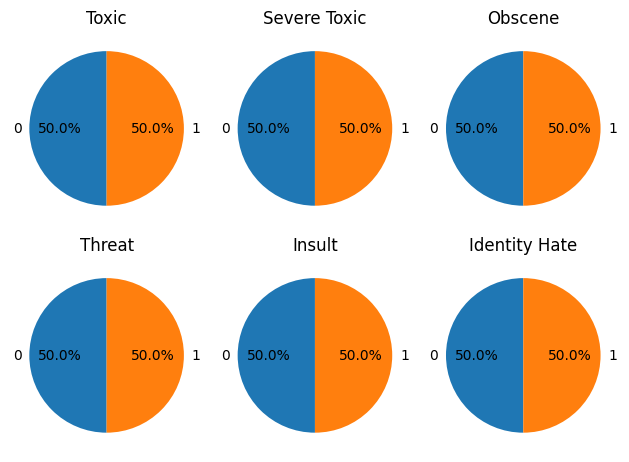

In [ ]:
# Mức độ phân bổ các lớp 0 và 1 ở từng thuộc tính sau khi tái cân bằng lớp (biểu đồ tròn)

toxic_counts = data_tox_done['toxic'].value_counts()
severe_toxic_counts = data_sev_done['severe_toxic'].value_counts()
obscene_counts = data_obs_done['obscene'].value_counts()
threat_counts = data_thr_done['threat'].value_counts()
insult_counts = data_ins_done['insult'].value_counts()
identity_hate_counts = data_ide_done['identity_hate'].value_counts()

fig, axes = plt.subplots(2, 3)

axes[0, 0].pie(toxic_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Toxic')

axes[0, 1].pie(severe_toxic_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Severe Toxic')

axes[0, 2].pie(obscene_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Obscene')

axes[1, 0].pie(threat_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Threat')

axes[1, 1].pie(insult_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Insult')

axes[1, 2].pie(identity_hate_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Identity Hate')

plt.tight_layout()
plt.show()


# Train mô hình

### Train trên nhiều mô hình khác nhau, đánh giá & chọn ra mô hình tốt nhất

In [ ]:
def cv_tf_train_test(df_done,label,vectorizer,ngram=(1, 1)):
    # Hợp nhất tập dữ liệu X, y
    X = df_done.comment_text
    y = df_done[label]

    # Tách tập dữ liệu để Train/Test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30, random_state=42)

    # Vectơ hóa chuỗi đầu vào bằng TF-IDF
    # ngrams = (1, 1): unigram (chỉ chia văn bản thành các từ đơn lẻ thay vì cụm từ)
    # stop_words: Loại bỏ các từ dừng English (các từ thường xuyên xuất hiện nhưng mang ít thông tin)
    vect = vectorizer(ngram_range=(ngram), stop_words='english')
    # Tính toán TF-IDF & biến đổi sang ma trận gồm các vectơ đặc trưng
    X_train_vectorized = vect.fit_transform(X_train)
    # Chỉ biến đổi văn bản sang ma trận sao cho phù hợp với không gian TF-IDF của tập Train
    X_test_vectorized = vect.transform(X_test)

    # Train trên nhiều mô hình khác nhau
    models = [LogisticRegression(), KNeighborsClassifier(n_neighbors=5), BernoulliNB(), MultinomialNB(), SVC(), RandomForestClassifier(n_estimators=100, random_state=42)]
    # Vị trí 0: Accuracy, 1: F1
    model_scores = {}

    for model in models:
        scores = []
        model_name = model.__class__.__name__
        # Đào tạo trên từng mô hình
        model.fit(X_train_vectorized, y_train)
        # Dự đoán tập Test
        y_pred = model.predict(X_test_vectorized)
        # Đánh giá chỉ số Accuracy
        acc = accuracy_score(y_pred, y_test)
        print('Accuracy:', acc)
        scores.append(acc)
        # Đánh giá chỉ số F1 Score
        f1 = f1_score(y_pred, y_test, average='macro')
        print('F1 Score:', f1)
        scores.append(f1)
        # Lưu kết quả
        model_scores[model_name] = scores
        # In bảng đánh giá phân loại
        print(classification_report(y_pred, y_test))
        # Vẽ ma trận nhầm lẫn
        cm = confusion_matrix(y_pred, y_test)
        plt.title(model_name)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.savefig(os.path.join(img_path, f'cm_{label.lower()}_{model_name}.jpg'))
        plt.show()

    # Chuyển đổi dictionary thành DataFrame
    df_scores = pd.DataFrame.from_dict(model_scores, orient='index', columns=[f'Accuracy', f'F1 Score'])

    # Thêm cột "Model" từ index của DataFrame
    df_scores.reset_index(inplace=True)
    df_scores.rename(columns={'index': 'Model'}, inplace=True)

    return df_scores

Accuracy: 0.864
F1 Score: 0.863930090304174
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1605
           1       0.82      0.90      0.86      1395

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.86      3000
weighted avg       0.87      0.86      0.86      3000



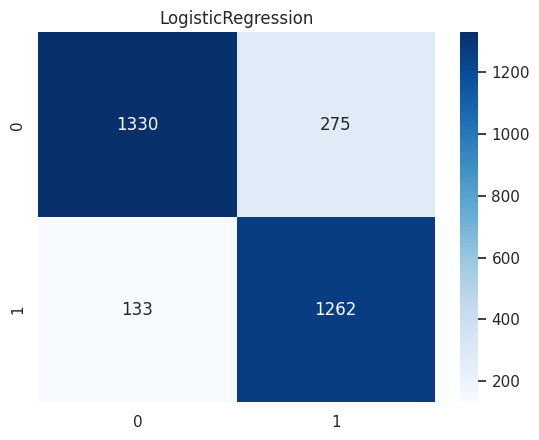

Accuracy: 0.534
F1 Score: 0.4242095580664204
              precision    recall  f1-score   support

           0       1.00      0.51      0.68      2847
           1       0.09      0.95      0.17       153

    accuracy                           0.53      3000
   macro avg       0.55      0.73      0.42      3000
weighted avg       0.95      0.53      0.65      3000



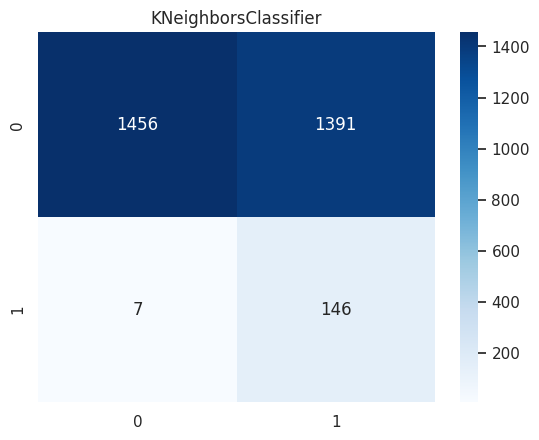

Accuracy: 0.723
F1 Score: 0.7063180494240924
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       822
           1       0.94      0.66      0.78      2178

    accuracy                           0.72      3000
   macro avg       0.72      0.77      0.71      3000
weighted avg       0.82      0.72      0.74      3000



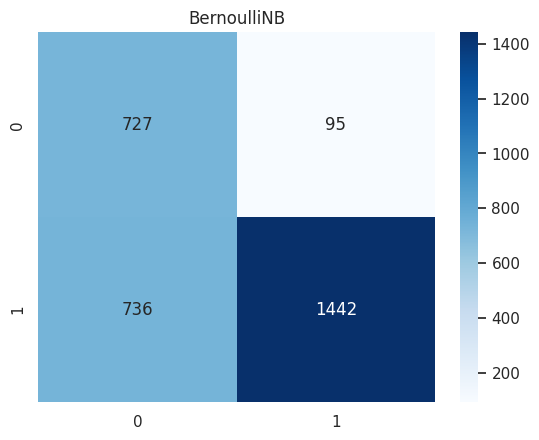

Accuracy: 0.876
F1 Score: 0.8759955358392901
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1555
           1       0.85      0.90      0.88      1445

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



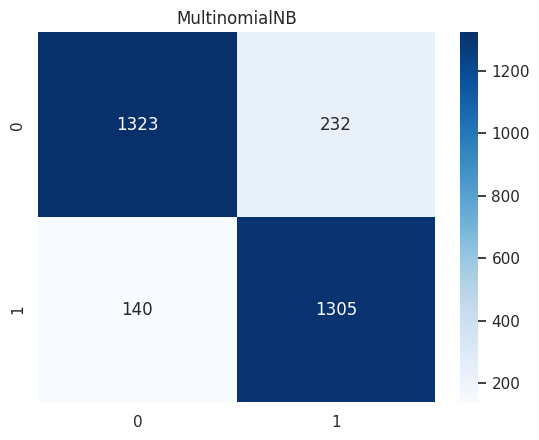

Accuracy: 0.8643333333333333
F1 Score: 0.8641854312679842
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1636
           1       0.81      0.91      0.86      1364

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.86      3000
weighted avg       0.87      0.86      0.86      3000



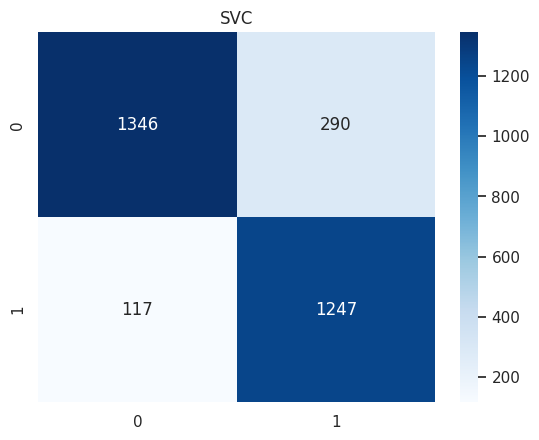

Accuracy: 0.8453333333333334
F1 Score: 0.8447365004410287
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1723
           1       0.76      0.92      0.84      1277

    accuracy                           0.85      3000
   macro avg       0.85      0.86      0.84      3000
weighted avg       0.86      0.85      0.85      3000



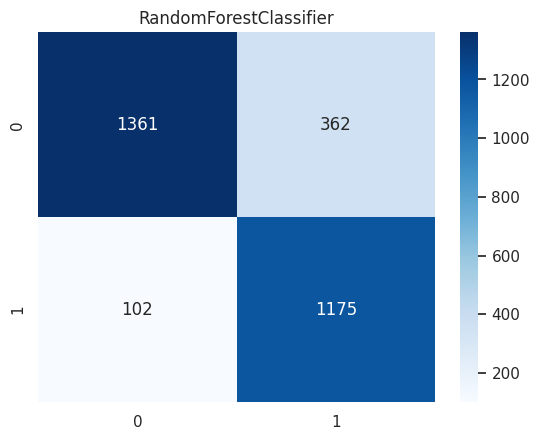

,Model,Accuracy,F1 Score
0,LogisticRegression,0.864000,0.863930
1,KNeighborsClassifier,0.534000,0.424210
2,BernoulliNB,0.723000,0.706318
3,MultinomialNB,0.876000,0.875996
4,SVC,0.864333,0.864185
5,RandomForestClassifier,0.845333,0.844737


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Toxic

df_tox = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox

Accuracy: 0.9311111111111111
F1 Score: 0.9311097503160557
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       465
           1       0.90      0.96      0.93       435

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



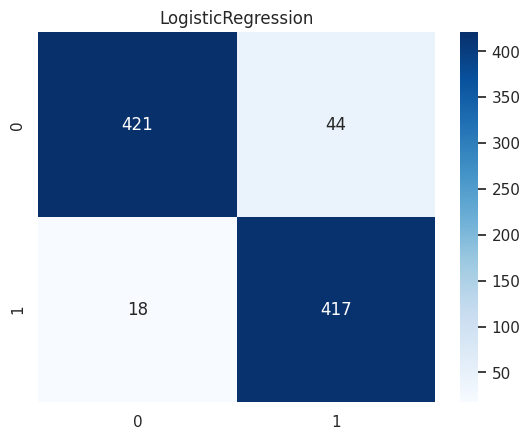

Accuracy: 0.8533333333333334
F1 Score: 0.8532746431906095
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       443
           1       0.85      0.86      0.86       457

    accuracy                           0.85       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.85      0.85      0.85       900



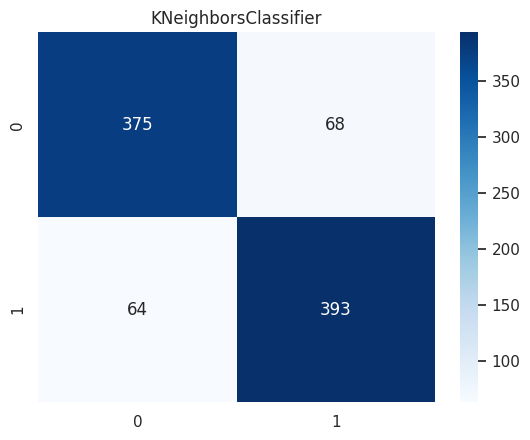

Accuracy: 0.7711111111111111
F1 Score: 0.757664798393843
              precision    recall  f1-score   support

           0       0.55      0.97      0.70       249
           1       0.98      0.70      0.81       651

    accuracy                           0.77       900
   macro avg       0.77      0.83      0.76       900
weighted avg       0.86      0.77      0.78       900



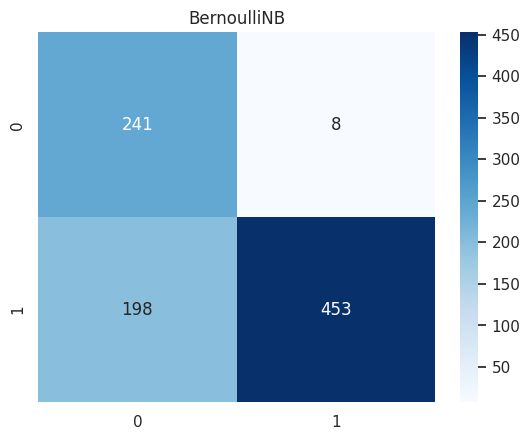

Accuracy: 0.9333333333333333
F1 Score: 0.93312693498452
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       411
           1       0.97      0.91      0.94       489

    accuracy                           0.93       900
   macro avg       0.93      0.94      0.93       900
weighted avg       0.94      0.93      0.93       900



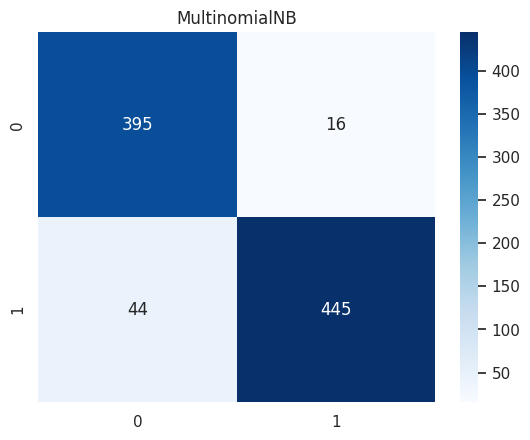

Accuracy: 0.9255555555555556
F1 Score: 0.9255532578165993
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       466
           1       0.90      0.95      0.93       434

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



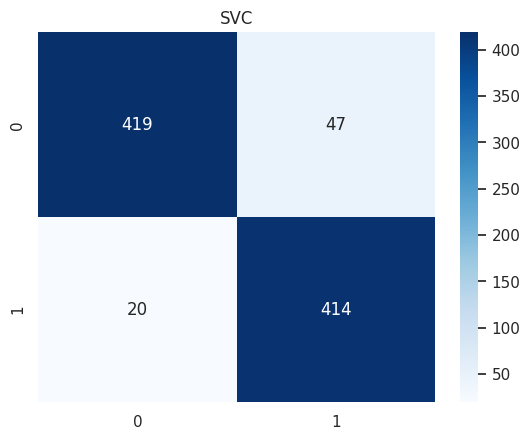

Accuracy: 0.93
F1 Score: 0.9299929992999301
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       452
           1       0.92      0.94      0.93       448

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



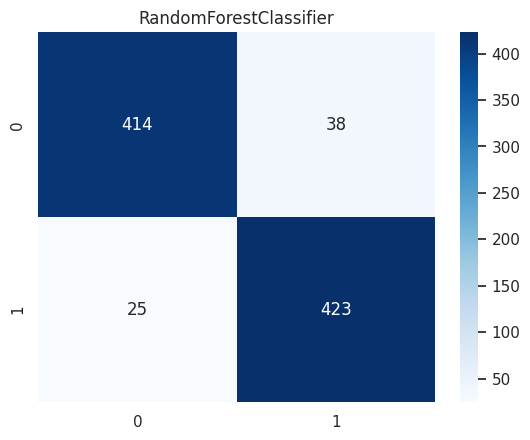

,Model,Accuracy,F1 Score
0,LogisticRegression,0.931111,0.931110
1,KNeighborsClassifier,0.853333,0.853275
2,BernoulliNB,0.771111,0.757665
3,MultinomialNB,0.933333,0.933127
4,SVC,0.925556,0.925553
5,RandomForestClassifier,0.930000,0.929993


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Severe_Toxic

df_sev = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev

Accuracy: 0.911
F1 Score: 0.9109413301273694
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1614
           1       0.86      0.96      0.91      1386

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000



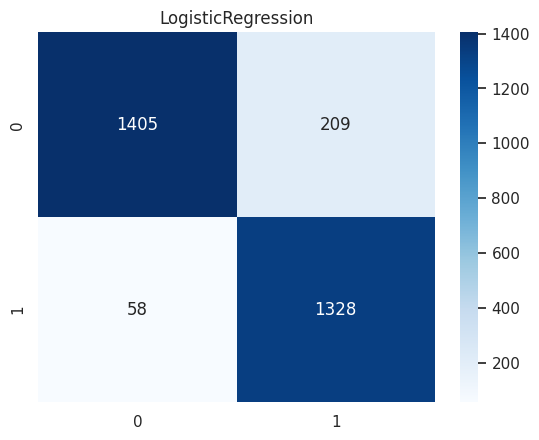

Accuracy: 0.5546666666666666
F1 Score: 0.462191296730853
              precision    recall  f1-score   support

           0       0.99      0.52      0.69      2781
           1       0.14      0.96      0.24       219

    accuracy                           0.55      3000
   macro avg       0.57      0.74      0.46      3000
weighted avg       0.93      0.55      0.65      3000



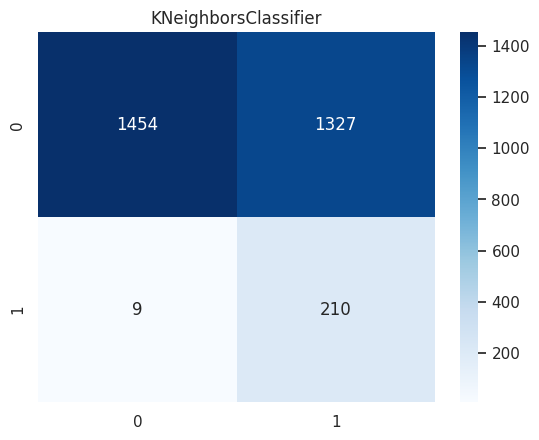

Accuracy: 0.7373333333333333
F1 Score: 0.7214676346334024
              precision    recall  f1-score   support

           0       0.51      0.91      0.65       821
           1       0.95      0.67      0.79      2179

    accuracy                           0.74      3000
   macro avg       0.73      0.79      0.72      3000
weighted avg       0.83      0.74      0.75      3000



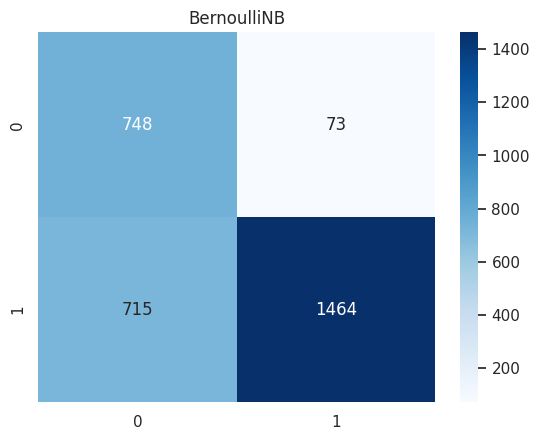

Accuracy: 0.9
F1 Score: 0.8999423668032787
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1465
           1       0.90      0.90      0.90      1535

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



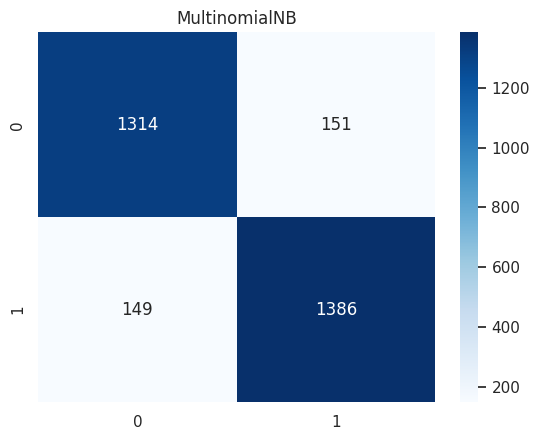

Accuracy: 0.912
F1 Score: 0.9119520627897411
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1607
           1       0.87      0.96      0.91      1393

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000



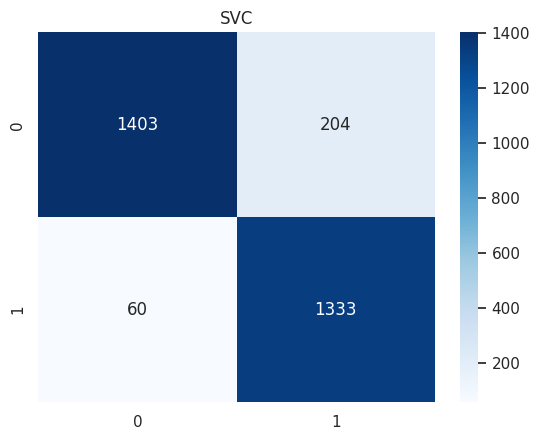

Accuracy: 0.9096666666666666
F1 Score: 0.9096570200440292
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1568
           1       0.88      0.94      0.91      1432

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



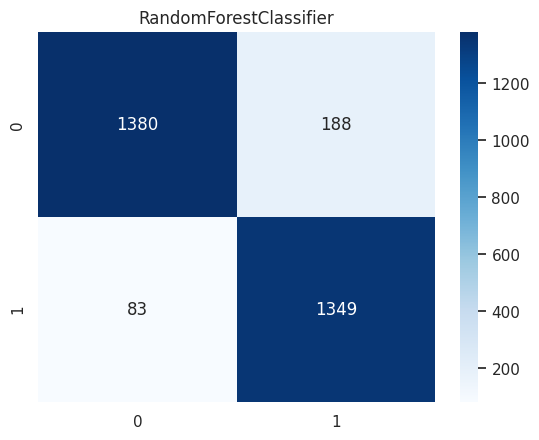

,Model,Accuracy,F1 Score
0,LogisticRegression,0.911000,0.910941
1,KNeighborsClassifier,0.554667,0.462191
2,BernoulliNB,0.737333,0.721468
3,MultinomialNB,0.900000,0.899942
4,SVC,0.912000,0.911952
5,RandomForestClassifier,0.909667,0.909657


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Obscene

df_obs = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs

Accuracy: 0.8986666666666666
F1 Score: 0.8986261171135121
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1597
           1       0.86      0.94      0.90      1403

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



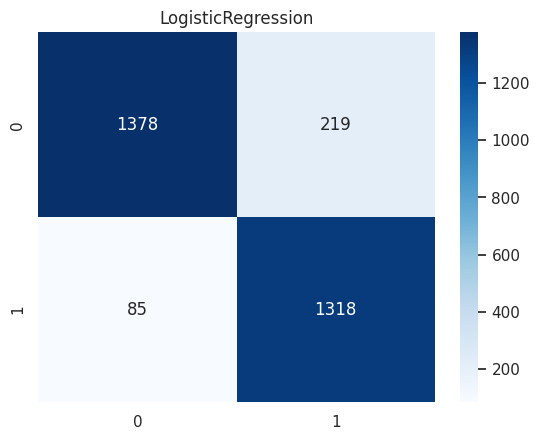

Accuracy: 0.5506666666666666
F1 Score: 0.454427715719605
              precision    recall  f1-score   support

           0       1.00      0.52      0.68      2797
           1       0.13      0.97      0.23       203

    accuracy                           0.55      3000
   macro avg       0.56      0.74      0.45      3000
weighted avg       0.94      0.55      0.65      3000



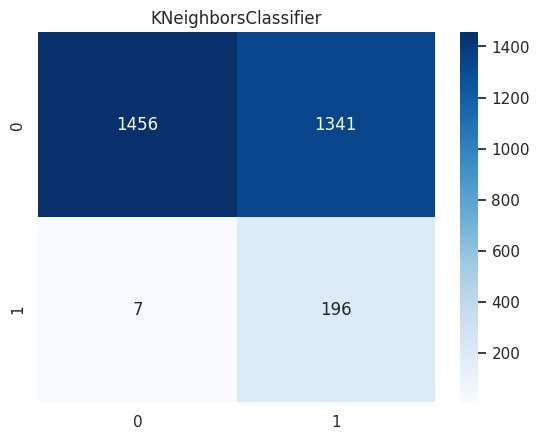

Accuracy: 0.734
F1 Score: 0.7190515443011354
              precision    recall  f1-score   support

           0       0.52      0.89      0.65       845
           1       0.94      0.67      0.78      2155

    accuracy                           0.73      3000
   macro avg       0.73      0.78      0.72      3000
weighted avg       0.82      0.73      0.75      3000



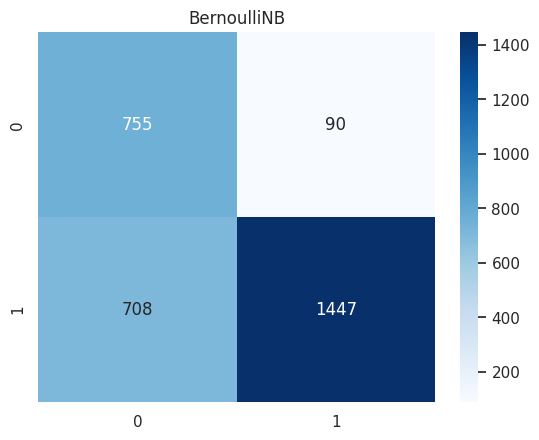

Accuracy: 0.895
F1 Score: 0.8949696462277599
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1486
           1       0.89      0.90      0.90      1514

    accuracy                           0.90      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.90      0.89      3000



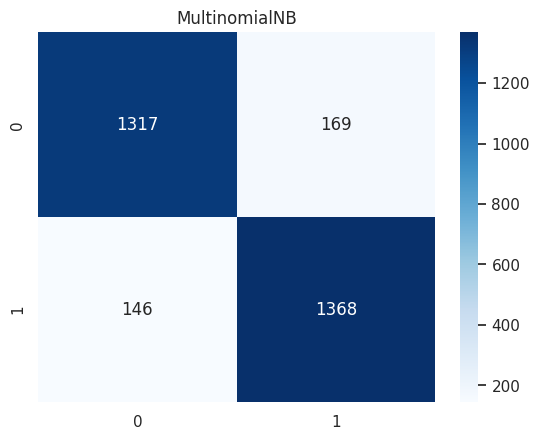

Accuracy: 0.8986666666666666
F1 Score: 0.8986233675805533
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1599
           1       0.86      0.94      0.90      1401

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



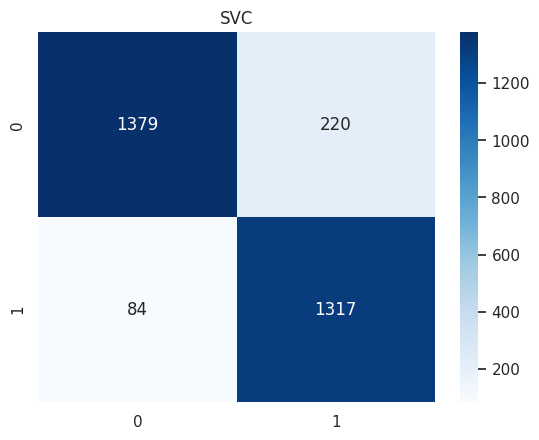

Accuracy: 0.89
F1 Score: 0.8899255896986362
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1615
           1       0.84      0.94      0.89      1385

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



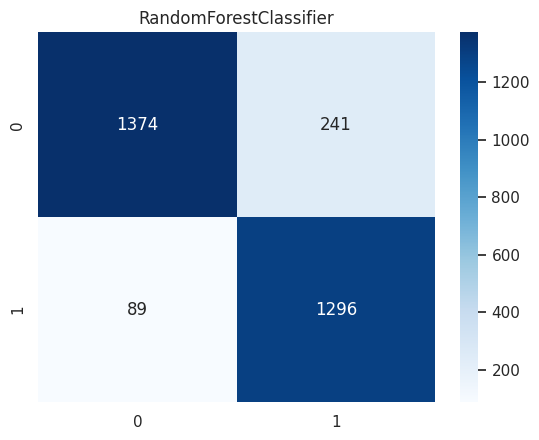

,Model,Accuracy,F1 Score
0,LogisticRegression,0.898667,0.898626
1,KNeighborsClassifier,0.550667,0.454428
2,BernoulliNB,0.734000,0.719052
3,MultinomialNB,0.895000,0.894970
4,SVC,0.898667,0.898623
5,RandomForestClassifier,0.890000,0.889926


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Insult

df_ins = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins

Accuracy: 0.9125
F1 Score: 0.9124984808764041
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       126
           1       0.87      0.96      0.91       114

    accuracy                           0.91       240
   macro avg       0.91      0.91      0.91       240
weighted avg       0.92      0.91      0.91       240



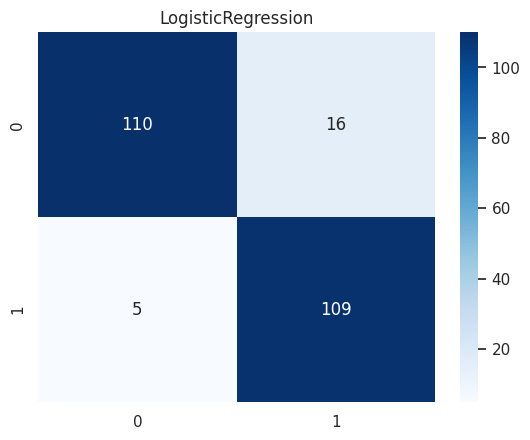

Accuracy: 0.8666666666666667
F1 Score: 0.8663324979114453
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       113
           1       0.88      0.87      0.87       127

    accuracy                           0.87       240
   macro avg       0.87      0.87      0.87       240
weighted avg       0.87      0.87      0.87       240



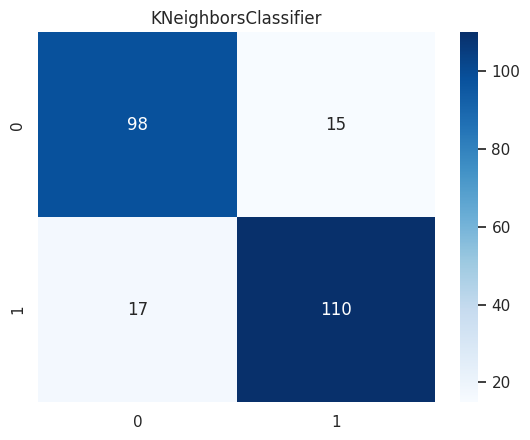

Accuracy: 0.775
F1 Score: 0.7589106332316393
              precision    recall  f1-score   support

           0       0.54      0.98      0.70        63
           1       0.99      0.70      0.82       177

    accuracy                           0.78       240
   macro avg       0.77      0.84      0.76       240
weighted avg       0.87      0.78      0.79       240



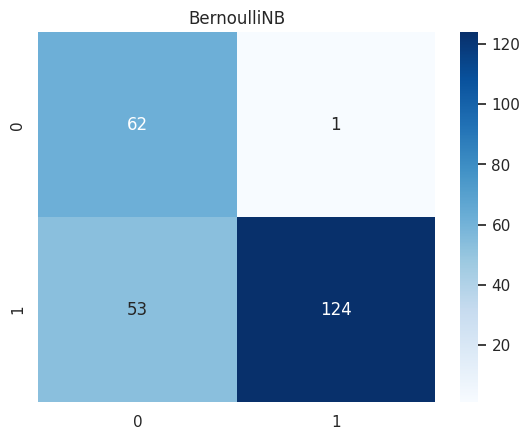

Accuracy: 0.925
F1 Score: 0.9242424242424243
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       101
           1       0.98      0.88      0.93       139

    accuracy                           0.93       240
   macro avg       0.92      0.93      0.92       240
weighted avg       0.93      0.93      0.93       240



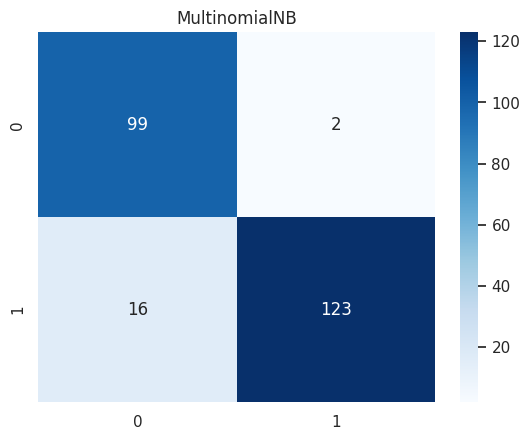

Accuracy: 0.9083333333333333
F1 Score: 0.9083269671504965
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       127
           1       0.86      0.96      0.91       113

    accuracy                           0.91       240
   macro avg       0.91      0.91      0.91       240
weighted avg       0.91      0.91      0.91       240



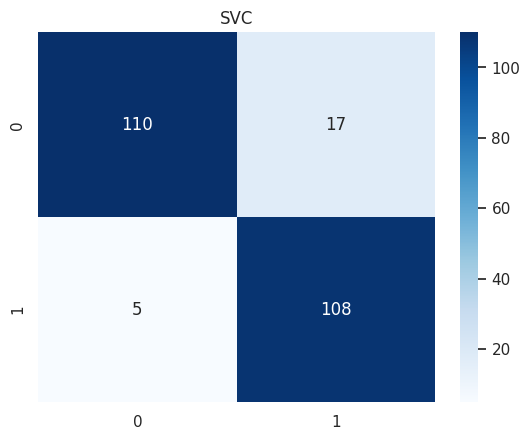

Accuracy: 0.9166666666666666
F1 Score: 0.9166435120866907
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       129
           1       0.86      0.97      0.92       111

    accuracy                           0.92       240
   macro avg       0.92      0.92      0.92       240
weighted avg       0.92      0.92      0.92       240



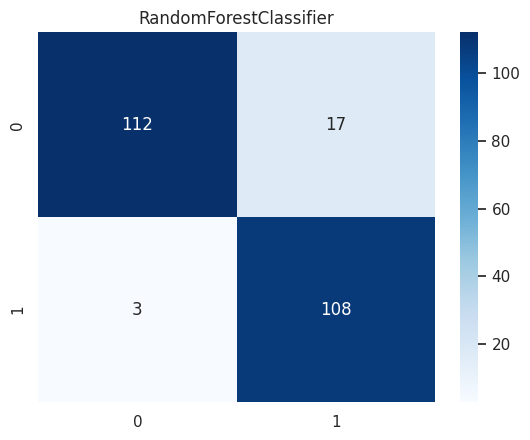

,Model,Accuracy,F1 Score
0,LogisticRegression,0.912500,0.912498
1,KNeighborsClassifier,0.866667,0.866332
2,BernoulliNB,0.775000,0.758911
3,MultinomialNB,0.925000,0.924242
4,SVC,0.908333,0.908327
5,RandomForestClassifier,0.916667,0.916644


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Threat

df_thr = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr

Accuracy: 0.8783333333333333
F1 Score: 0.8782112062373657
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       321
           1       0.84      0.91      0.87       279

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



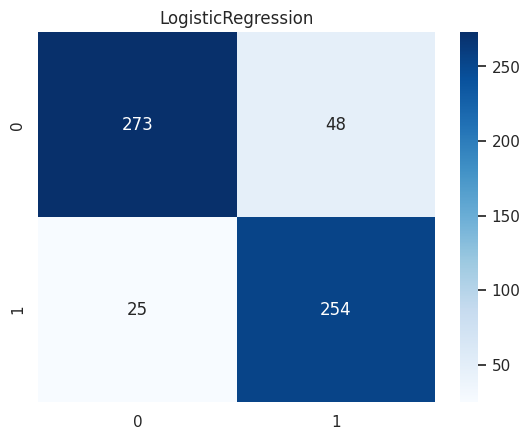

Accuracy: 0.8066666666666666
F1 Score: 0.8058035714285714
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       342
           1       0.74      0.86      0.79       258

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600



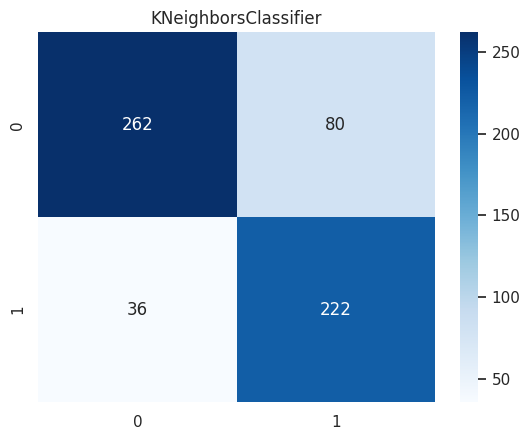

Accuracy: 0.7066666666666667
F1 Score: 0.6865501519756839
              precision    recall  f1-score   support

           0       0.46      0.91      0.61       150
           1       0.95      0.64      0.77       450

    accuracy                           0.71       600
   macro avg       0.71      0.77      0.69       600
weighted avg       0.83      0.71      0.73       600



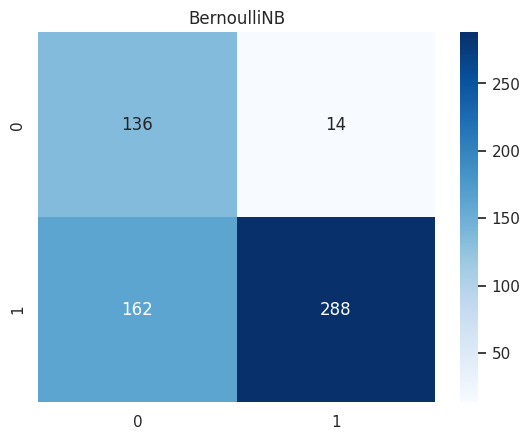

Accuracy: 0.8866666666666667
F1 Score: 0.8864193131709056
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       274
           1       0.93      0.86      0.89       326

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



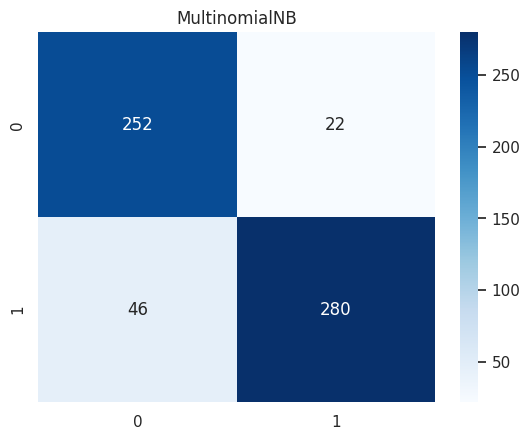

Accuracy: 0.8766666666666667
F1 Score: 0.8765555666766757
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       320
           1       0.84      0.91      0.87       280

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



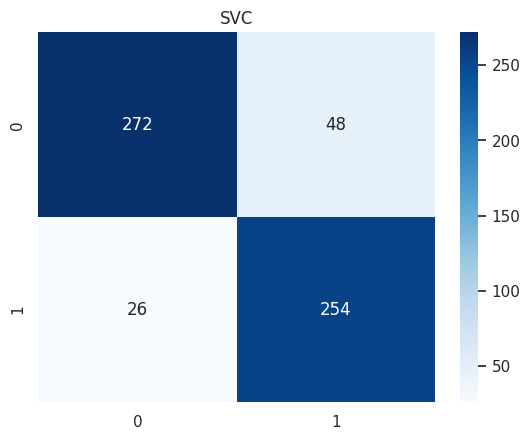

Accuracy: 0.8866666666666667
F1 Score: 0.886586016723003
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       318
           1       0.85      0.91      0.88       282

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



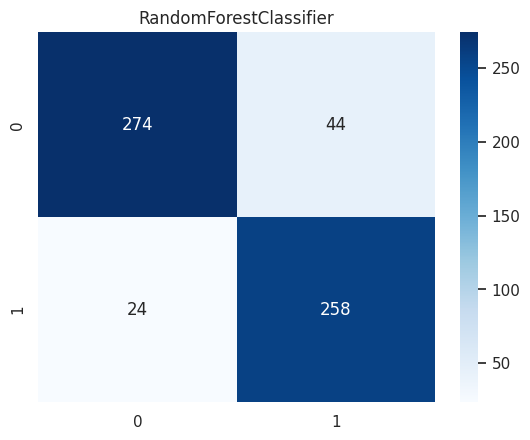

,Model,Accuracy,F1 Score
0,LogisticRegression,0.878333,0.878211
1,KNeighborsClassifier,0.806667,0.805804
2,BernoulliNB,0.706667,0.686550
3,MultinomialNB,0.886667,0.886419
4,SVC,0.876667,0.876556
5,RandomForestClassifier,0.886667,0.886586


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Identity Hate

df_ide = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide

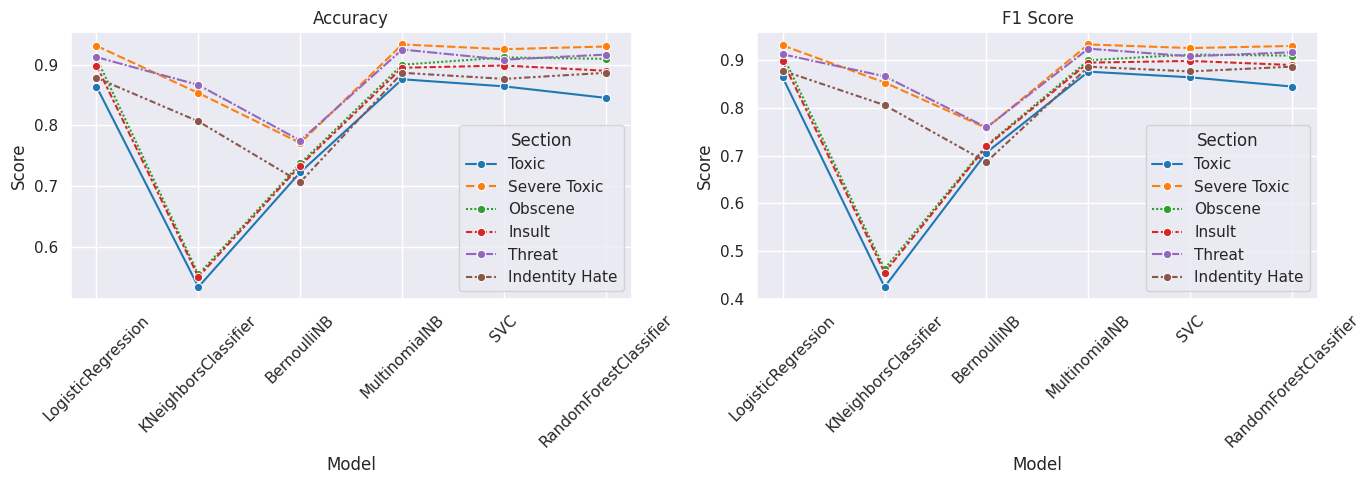

In [ ]:
# Vẽ biểu đồ đường đánh giá độ ổn định của các thuật toán

# Thêm cột 'Section' để phân biệt các nhóm
df_tox['Section'] = 'Toxic'
df_sev['Section'] = 'Severe Toxic'
df_obs['Section'] = 'Obscene'
df_ins['Section'] = 'Insult'
df_thr['Section'] = 'Threat'
df_ide['Section'] = 'Indentity Hate'

# Hợp nhất các DataFrame
df_combined = pd.concat([df_tox, df_sev, df_obs, df_ins, df_thr, df_ide], ignore_index=True)

# Chuyển đổi DataFrame thành định dạng dài (long format) cho Seaborn
df_long = df_combined.melt(id_vars=['Model', 'Section'], var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 5))
# Accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=df_long[df_long['Metric'].str.contains('Accuracy')], x='Model', y='Score', hue='Section', style='Section', palette='tab10', marker='o')
plt.title('Accuracy')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)

# F1 Score
plt.subplot(1, 2, 2)
sns.lineplot(data=df_long[df_long['Metric'].str.contains('F1 Score')], x='Model', y='Score', hue='Section', style='Section', palette='tab10', marker='o')
plt.title('F1 Score')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(img_path, 'acc_f1_models.jpg'))
plt.show()

### Train lại trên mô hình tốt nhất (SVM)

=== Đánh giá mô hình trên thuộc tính toxic ===
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1555
           1       0.85      0.90      0.88      1445

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



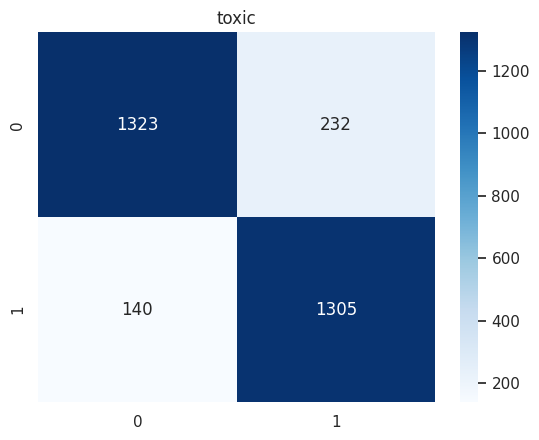

=== Đánh giá mô hình trên thuộc tính severe_toxic ===
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       411
           1       0.97      0.91      0.94       489

    accuracy                           0.93       900
   macro avg       0.93      0.94      0.93       900
weighted avg       0.94      0.93      0.93       900



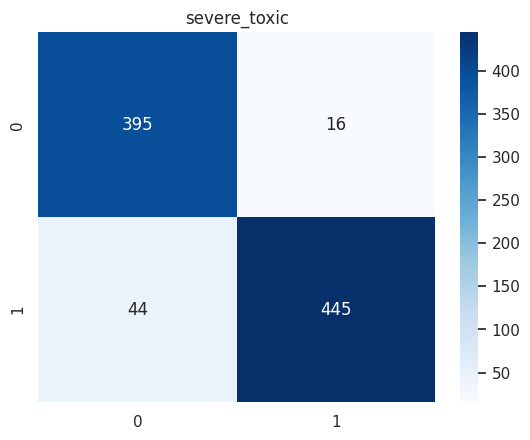

=== Đánh giá mô hình trên thuộc tính obscene ===
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1465
           1       0.90      0.90      0.90      1535

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



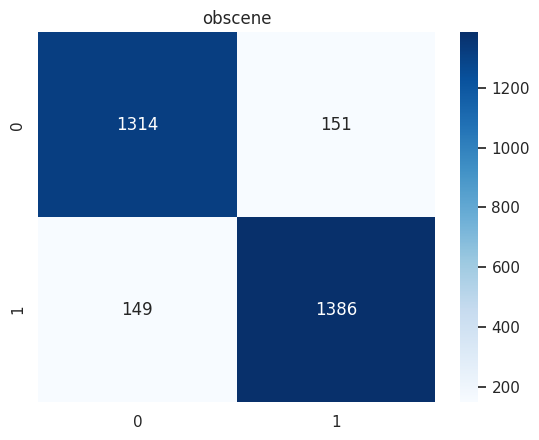

=== Đánh giá mô hình trên thuộc tính insult ===
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1486
           1       0.89      0.90      0.90      1514

    accuracy                           0.90      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.90      0.89      3000



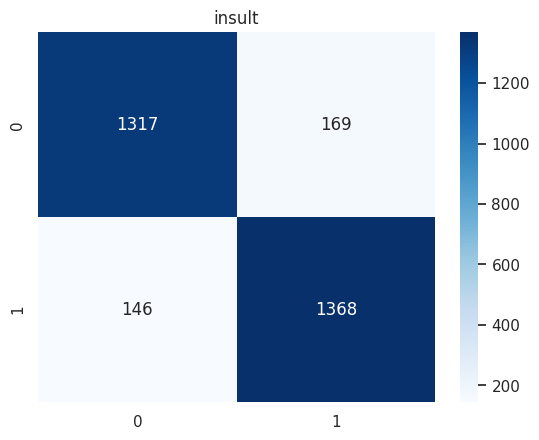

=== Đánh giá mô hình trên thuộc tính threat ===
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       101
           1       0.98      0.88      0.93       139

    accuracy                           0.93       240
   macro avg       0.92      0.93      0.92       240
weighted avg       0.93      0.93      0.93       240



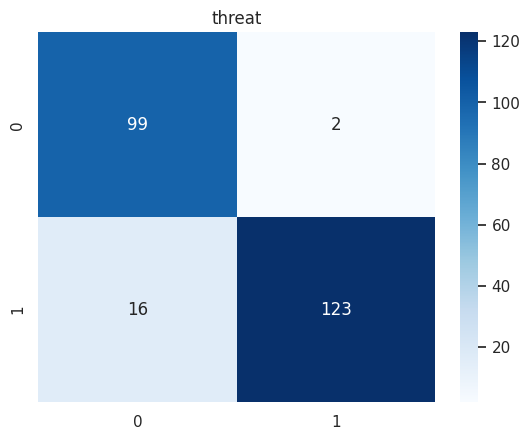

=== Đánh giá mô hình trên thuộc tính identity_hate ===
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       274
           1       0.93      0.86      0.89       326

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



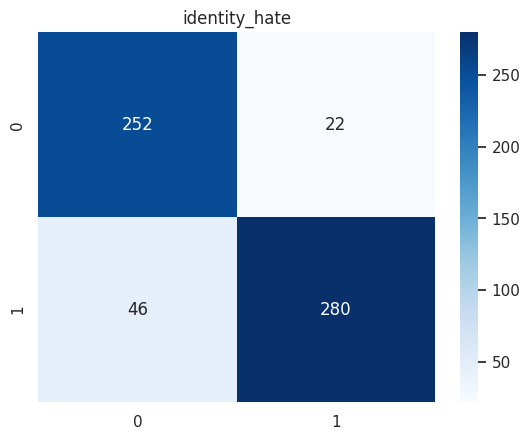

In [ ]:
data_dict = {
    'toxic': data_tox_done,
    'severe_toxic': data_sev_done,
    'obscene': data_obs_done,
    'insult': data_ins_done,
    'threat': data_thr_done,
    'identity_hate': data_ide_done
}

# Fit lại mô hình tốt nhất
def fit_data_with_best_model(X, y, label):
  # Tách tập dữ liệu để Train/Test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Vectơ hóa dữ liệu chuỗi
  tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

  X_train_fit = tfv.fit_transform(X_train)
  X_test_fit = tfv.transform(X_test)

  # Bắt đầu Train mô hình
  model = MultinomialNB()
  model.fit(X_train_fit, y_train)
  pred_test = model.predict(X_test_fit)

  print(f'=== Đánh giá mô hình trên thuộc tính {label} ===')
  # In bảng thống kê phân loại
  print(classification_report(pred_test, y_test))

  # Vẽ ma trận nhầm lẫn
  cm = confusion_matrix(pred_test, y_test)
  plt.title(label)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.show()

  return model, tfv

for idx, value in data_dict.items():
  # Bắt đầu Train mô hình tốt nhất trên các thuộc tính
  model_fitted, tfv = fit_data_with_best_model(value['comment_text'], value[idx], idx)

  # Lưu mô hình
  with open(os.path.join(model_path, f'{idx}_model.pkl'), 'wb') as f:
    pickle.dump([model_fitted, tfv], f)


# Dự đoán dữ liệu mới

Nhập dữ liệu mới: Fuck you nigga !
=== Output ===
toxic : 0.973
severe_toxic : 0.922
obscene : 0.978
insult : 0.973
threat : 0.714
identity_hate : 0.947


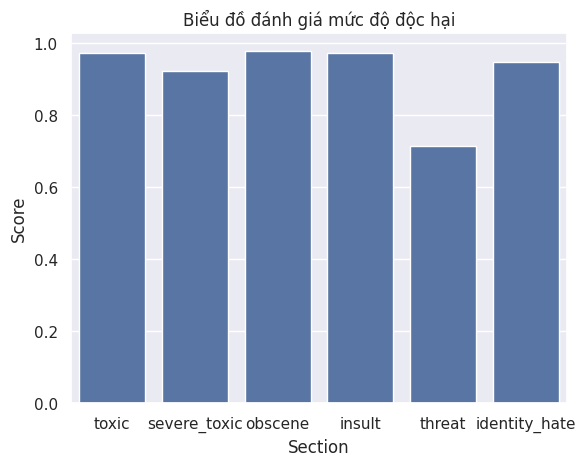

Nhập dữ liệu mới: Hello. How are you.?
=== Output ===
toxic : 0.371
severe_toxic : 0.51
obscene : 0.483
insult : 0.445
threat : 0.496
identity_hate : 0.483


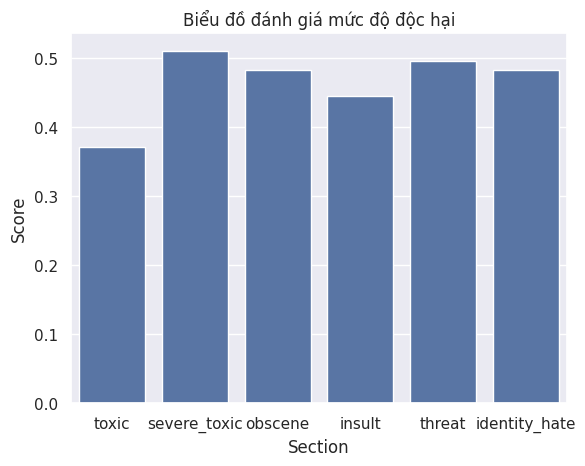

Nhập dữ liệu mới: exit


In [ ]:
# Dự đoán dữ liệu mới

models_list = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']
models_data = {}
y_proba = []
colors = sns.color_palette('pastel')

# Nạp mô hình đã Train vào bộ nhớ
for model in models_list:
  with open(os.path.join(model_path, f'{model}_model.pkl'), 'rb') as f:
    models_data[model] = pickle.load(f)

while True:
  y_proba.clear()
  input_text = input('Nhập dữ liệu mới: ')

  if input_text.lower() == "exit":
    break

  print('=== Output ===')
  for idx, value in models_data.items():
    model_name, model, tfv = idx, value[0], value[1]
    text_preprocessed = text_preprocessing(input_text)
    text_vectorized = tfv.transform([text_preprocessed])
    result = np.round(model.predict_proba(text_vectorized)[:, 1], 3)[0]
    print(model_name,':',result)
    y_proba.append(result)

  sns.barplot(x=models_list, y=y_proba)
  plt.title('Biểu đồ đánh giá mức độ độc hại')
  plt.xlabel('Section')
  plt.ylabel('Score')
  plt.show()